## Plot model predictions
Natalia Vélez, January 2022

In [11]:
%matplotlib inline

import os, json, re, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
from matplotlib.patches import Rectangle
from matplotlib import colors
from matplotlib.backends import backend_pdf
import seaborn as sns
from ast import literal_eval as eval_tuple
from scipy.spatial import distance

sys.path.append('..')
from utils import int_extract, read_json, gsearch, str_extract

sns.set_context('talk')
sns.set_style('white')

# Make directory to store plots in 
os.makedirs('plots/all_model_predictions', exist_ok=True) # avg heatmaps

Load problems:

In [3]:
with open('inputs/problems.json', 'r') as f:
    problems = json.load(f)

Exclude wiggly participants:

In [4]:
teachers = np.loadtxt('../1_preprocessing/outputs/valid_participants.txt', dtype=int)
print(teachers)

[ 1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24 25 26
 27 28 29 30]


Load human behavioral data

In [38]:
eval_tuple(human_df.cursor_coords[0])

[0, 0]

In [43]:
def read_coords(e):
    coords = eval_tuple(e)
    idx = np.ravel_multi_index(coords, (6,6))
    
    return idx

human_df = pd.read_csv('outputs/teaching_behavior.csv')
human_df = human_df.drop(columns=['onset', 'order', 'rating']) # drop columns that are irrelevant for model
human_df = human_df[human_df.subject.isin(teachers)] # exclude wiggly participants
human_df = human_df[~pd.isna(human_df.example)] # exclude trials where teachers failed to respond

# keep track of cursor locations
grouped_df = human_df.groupby(['subject', 'run', 'block_idx'])
human_df['cursor_coords'] = grouped_df['example'].shift()
human_df.loc[grouped_df.head(1).index, 'cursor_coords'] = 'start'
human_df['cursor_coords'] = np.where(human_df.cursor_coords == 'start', human_df.start, human_df.cursor_coords)
human_df['cursor_coords'] = human_df['cursor_coords'].astype(str).apply(eval_tuple)

# keep examples in coord form, just in case
human_df['example_coords'] = human_df.example.apply(eval_tuple)

# convert tuples of coordinates into flat indices
# human_df['example'] = human_df.example.apply(read_coords)
# human_df['cursor'] = human_df.cursor_coords.apply(read_coords)

print(human_df.shape)
human_df.head(15)

(3213, 10)


,subject,run,block_idx,ex_idx,first_movement,start,problem,example,cursor_coords,example_coords
0,1,1,0,0,"[0, 1]","[0, 0]",22,"[1, 2]","[0, 0]","[1, 2]"
1,1,1,0,1,"[0, 1]","[0, 0]",22,"[4, 3]","[1, 2]","[4, 3]"
3,1,1,1,0,"[0, 4]","[0, 5]",18,"[0, 3]","[0, 5]","[0, 3]"
4,1,1,1,1,"[0, 4]","[0, 5]",18,"[5, 2]","[0, 3]","[5, 2]"
5,1,1,1,2,"[0, 4]","[0, 5]",18,"[1, 1]","[5, 2]","[1, 1]"
6,1,1,2,0,"[5, 4]","[5, 5]",1,"[5, 1]","[5, 5]","[5, 1]"
7,1,1,2,1,"[5, 4]","[5, 5]",1,"[0, 1]","[5, 1]","[0, 1]"
8,1,1,2,2,"[5, 4]","[5, 5]",1,"[0, 4]","[0, 1]","[0, 4]"
10,1,1,3,1,"[5, 1]","[5, 0]",16,"[4, 3]","[5, 0]","[4, 3]"
11,1,1,3,2,"[5, 1]","[5, 0]",16,"[1, 2]","[4, 3]","[1, 2]"


Load parameter fits

In [44]:
opt_files = gsearch('outputs/fit_model-*_method-optimize/*.json')
opt_list = []
for f in opt_files:
    sub = str_extract('sub-[0-9]{2}', f)
    res = read_json(f)
    weight,temp = res['x']
    lik = -res['fun']
    opt_list.append((sub, weight, temp, lik))

opt_df = pd.DataFrame(opt_list, columns=['subject', 'weight', 'temp', 'loglik'])
opt_df['model'] = 'utility'
opt_mle = (
    opt_df
    .melt(id_vars='subject', value_vars=['weight', 'temp'], var_name='parameter')
)

opt_mle.head()

,subject,parameter,value
0,sub-01,weight,0.047737
1,sub-02,weight,0.007230
2,sub-21,weight,0.339530
3,sub-20,weight,0.233767
4,sub-26,weight,0.034858


[(0.0, 1.0)]

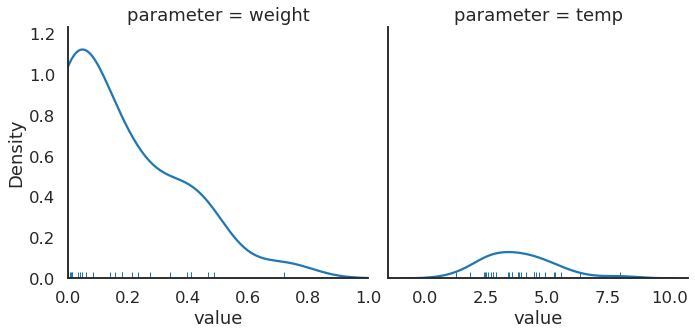

In [45]:
g = sns.displot(data=opt_mle, x='value', col='parameter', kind='kde', rug=True, facet_kws={'sharex': False})
g.axes[0][0].set(xlim=(0,1))

In [46]:
opt_mle.groupby('parameter').agg(['min', 'max', 'mean'])

value                    
                    min       max      mean
parameter                                  
temp       1.270296e+00  7.990471  3.839839
weight     2.171832e-09  0.718638  0.175604

Compare weight to distance travelled:

In [55]:
distance_travelled = human_df.copy()
distance_travelled['distance'] = distance_travelled.apply(lambda row: distance.cityblock(row.cursor_coords, row.example_coords), axis=1)
distance_travelled['subject'] = distance_travelled.subject.apply(lambda s: 'sub-%02d' % s)

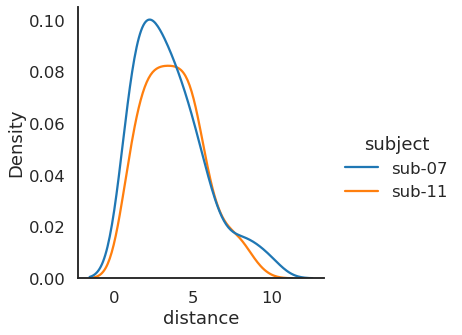

In [56]:
example_subjs = distance_travelled[distance_travelled.subject.isin(['sub-07', 'sub-11'])].copy()
sns.displot(data=example_subjs, x='distance', hue='subject', kind='kde')

Number of observations

<AxesSubplot:xlabel='distance', ylabel='value'>

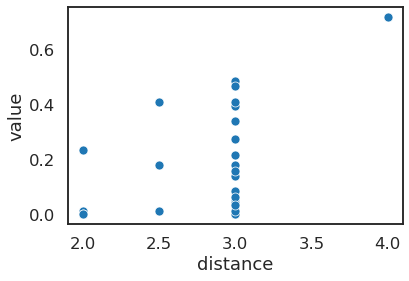

In [67]:
weights = opt_mle[opt_mle.parameter=='weight'].copy()
avg_distance = distance_travelled.merge(weights)
ax = sns.scatterplot(data=avg_distance,x='distance',y='value')
ax.set(xlabel='Median distance travelled', y='')

In [22]:
n_obs = human_df.groupby('subject')['example'].agg('count').reset_index()
n_obs['subject'] = n_obs.subject.apply(lambda s: 'sub-%02d' % s)
n_obs.head()

,subject,example
0,sub-01,108
1,sub-02,114
2,sub-04,113
3,sub-05,114
4,sub-06,115


In [14]:
param_files = gsearch('outputs/fit_model-*_method-grid/*params.csv')
param_files.sort()
param_df= pd.concat([pd.read_csv(f) for f in param_files])
print(param_df.shape)
param_df.head()

(5643, 5)


,model,temp,weight,loglik,subject
0,cost,0.1,0.0,-256.503829,1
1,cost,0.2,0.0,-255.837364,1
2,cost,0.3,0.0,-255.202265,1
3,cost,0.4,0.0,-254.598491,1
4,cost,0.5,0.0,-254.025985,1


In [16]:
pred_files = gsearch('outputs/fit_model-*_method-grid/*predictions.csv')
pred_files.sort()
pred_df= pd.concat([pd.read_csv(f) for f in pred_files])
print(pred_df.shape)
pred_df.head()

(9747, 22)


,subject,run,block_idx,ex_idx,first_movement,start,problem,example,cursor_coords,example_coords,...,lik,pD,pTrue,pH,entropy,delta,KL,temp,weight,loglik
0,1,7,2,0,"[1, 5]","[0, 5]",0,33,"[0, 5]","[5, 3]",...,0.023144,"[(0, 0.0), (1, 0.0), (2, 0.06044423289900122),...",0.521739,"[('A', 0.5217391304347826), ('B', 0.0), ('C', ...",0.692202,0.271739,0.694093,2.4,0.0,-3.766034
1,1,7,2,1,"[1, 5]","[0, 5]",0,32,"[5, 3]","[5, 2]",...,0.080194,"[(0, 0.0), (1, 0.0), (2, 0.024154050852626435)...",0.417190,"[('A', 0.41718991964375146), ('B', 0.0), ('C',...",0.679369,-0.104549,0.021930,2.4,0.0,-2.523303
2,1,7,2,2,"[1, 5]","[0, 5]",0,2,"[5, 2]","[0, 2]",...,0.033383,"[(0, 0.0), (1, 0.0), (2, 0.03338293698494832),...",1.000000,"[('A', 1.0), ('B', 0.0), ('C', 0.0), ('D', 0.0)]",0.000000,0.582810,0.874214,2.4,0.0,-3.399710
3,1,1,2,0,"[5, 4]","[5, 5]",1,31,"[5, 5]","[5, 1]",...,0.047061,"[(0, 0.0), (1, 0.014174371399627647), (2, 0.01...",0.241830,"[('A', 0.2418300653594771), ('B', 0.3790849673...",1.078704,-0.008170,0.307591,2.4,0.0,-3.056320
4,1,1,2,1,"[5, 4]","[5, 5]",1,1,"[5, 1]","[0, 1]",...,0.032237,"[(0, 0.0), (1, 0.032237069436649675), (2, 0.02...",1.000000,"[('A', 1.0), ('B', 0.0), ('C', 0.0), ('D', 0.0)]",0.000000,0.758170,1.419520,2.4,0.0,-3.434638


In [20]:
best_preds = pred_df.groupby(['model','subject', 'weight', 'temp'])['loglik'].agg('sum').reset_index()
best_preds['subject'] = best_preds.subject.apply(lambda s: 'sub-%02d' % s)
best_preds = best_preds[best_preds.model != 'utility']
best_preds

,model,subject,weight,temp,loglik
0,cost,sub-01,0.0,2.4,-248.914475
1,cost,sub-02,0.0,2.8,-260.084130
2,cost,sub-04,0.0,3.4,-252.657737
3,cost,sub-05,0.0,2.5,-263.763369
4,cost,sub-06,0.0,2.3,-267.476600
...,...,...,...,...,...
79,strong,sub-26,0.0,0.0,-276.044181
80,strong,sub-27,0.0,0.0,-274.498038
81,strong,sub-28,0.0,0.0,-282.035645
82,strong,sub-29,0.0,0.0,-275.279359


In [29]:
all_mle = pd.concat([best_preds, opt_df])
all_mle['model'] = all_mle.model.str.title()
print(all_mle.shape)
all_mle.head()

(112, 5)


,model,subject,weight,temp,loglik
0,Cost,sub-01,0.0,2.4,-248.914475
1,Cost,sub-02,0.0,2.8,-260.084130
2,Cost,sub-04,0.0,3.4,-252.657737
3,Cost,sub-05,0.0,2.5,-263.763369
4,Cost,sub-06,0.0,2.3,-267.476600


<AxesSubplot:xlabel='model', ylabel='loglik'>

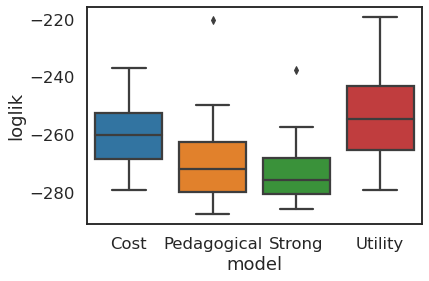

In [30]:
sns.boxplot(data=all_mle, x='model', y='loglik')

Best model by participant

KeyError: 'Column not found: BIC'

<AxesSubplot:xlabel='temp', ylabel='loglik'>

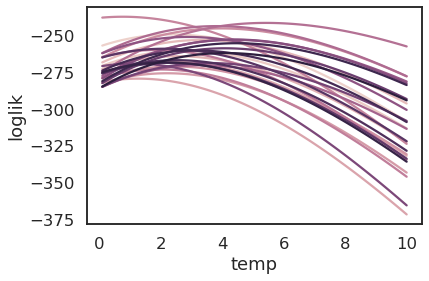

In [25]:
sns.lineplot(data=param_df[param_df.model == 'cost'], x='temp', y='loglik', hue='subject', legend=False)

In [ ]:
sns.lineplot(data=param_df[param_df.model == 'pedagogical'], x='temp', y='loglik', hue='subject', legend=False)

Load model predictions

## Check parameter fits

### Cost-minimizing model

Check evidence curves

NameError: name 'cost_params' is not defined

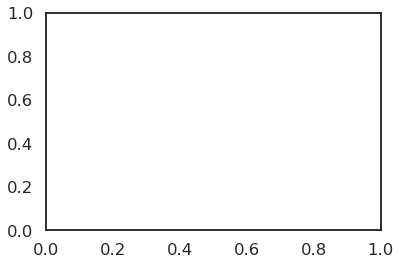

In [43]:
fig,ax=plt.subplots()
sns.lineplot(data=cost_params, x='tau', y='loglik', hue='sub', legend=False)
ax.set(xlabel='Laziness (tau)', ylabel='Log likelihood')

Plot distribution of best parameters

In [54]:
cost_best = cost_df.groupby(['subject', 'tau']).agg({'loglik': 'sum', 'example': 'count'}).reset_index()
cost_best['model'] = 'cost'
cost_best.head()

,subject,tau,loglik,example,model
0,1,2.4,-248.914475,108,cost
1,2,2.8,-260.084130,114,cost
2,4,3.4,-252.657737,113,cost
3,5,2.5,-263.763369,114,cost
4,6,2.3,-267.476600,115,cost


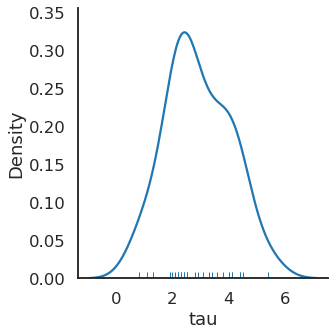

In [55]:
g = sns.displot(cost_best.tau, kind='kde', rug=True)

### Utility-maximizing model

[Text(0.5, 0, 'Laziness (tau)'), Text(0, 0.5, 'Log likelihood')]

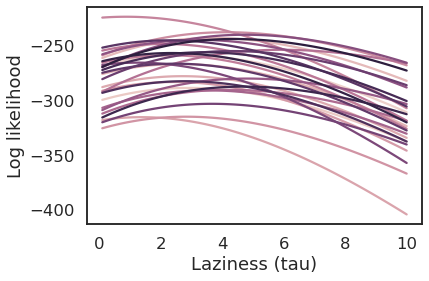

In [43]:
fig,ax=plt.subplots()
sns.lineplot(data=utility_params, x='tau', y='loglik', hue='sub', legend=False)
ax.set(xlabel='Laziness (tau)', ylabel='Log likelihood')

In [52]:
utility_df.head()

,subject,run,block_idx,ex_idx,first_movement,start,problem,example,cursor_coords,example_coords,...,model,lik,pD,pTrue,pH,entropy,delta,KL,tau,loglik
0,1,7,2,0,"[1, 5]","[0, 5]",0,33,"[0, 5]","[5, 3]",...,utility,0.049220,"[(0, 0.0), (1, 0.0), (2, 0.032515287534691566)...",0.709270,"[('A', 0.7092697265561709), ('B', 0.0), ('C', ...",0.602804,0.459270,0.783490,2.7,-3.011447
1,1,7,2,1,"[1, 5]","[0, 5]",0,32,"[5, 3]","[5, 2]",...,utility,0.055502,"[(0, 0.0), (1, 0.0), (2, 0.04156539403090806),...",0.346161,"[('A', 0.3461611284212899), ('B', 0.0), ('C', ...",0.645038,-0.363109,0.281601,2.7,-2.891338
2,1,7,2,2,"[1, 5]","[0, 5]",0,2,"[5, 2]","[0, 2]",...,utility,0.058580,"[(0, 0.0), (1, 0.0), (2, 0.05857958519827925),...",1.000000,"[('A', 1.0), ('B', 0.0), ('C', 0.0), ('D', 0.0)]",0.000000,0.653839,1.060851,2.7,-2.837369
3,1,1,2,0,"[5, 4]","[5, 5]",1,31,"[5, 5]","[5, 1]",...,utility,0.005807,"[(0, 0.0), (1, 0.036215519437914415), (2, 0.04...",0.030642,"[('A', 0.030641993268484585), ('B', 0.48467900...",0.808875,-0.219358,0.577420,2.7,-5.148618
4,1,1,2,1,"[5, 4]","[5, 5]",1,1,"[5, 1]","[0, 1]",...,utility,0.088993,"[(0, 0.0), (1, 0.08899325727782517), (2, 0.067...",1.000000,"[('A', 1.0), ('B', 0.0), ('C', 0.0), ('D', 0.0)]",0.000000,0.969358,3.485384,2.7,-2.419195


In [53]:
utility_best = utility_df.groupby(['subject', 'tau']).agg({'loglik': 'sum', 'example': 'count'}).reset_index()
utility_best['model'] = 'utility'
utility_best.head()

,subject,tau,loglik,example,model
0,1,2.7,-258.718470,108,utility
1,2,2.9,-288.622350,114,utility
2,4,3.7,-243.071045,113,utility
3,5,2.6,-266.858134,114,utility
4,6,2.7,-277.929758,115,utility


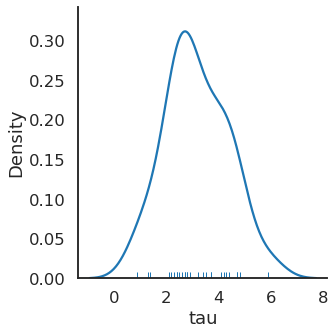

In [49]:
g = sns.displot(utility_best.tau, kind='kde', rug=True)

## Model comparison

Calculate BIC

In [53]:
model_bic = pd.merge(all_mle, n_obs)
model_bic['free_params'] = np.where(model_bic['model'] == 'Strong', 0, np.where(model_bic['model'] == 'Utility', 2, 1))
model_bic['BIC'] = model_bic.free_params*np.log(model_bic.example)-2*model_bic.loglik

print(model_bic.shape)
model_bic.head()

(112, 8)


,model,subject,weight,temp,loglik,example,free_params,BIC
0,Cost,sub-01,0.000000,2.400000,-248.914475,108,1,502.511082
1,Pedagogical,sub-01,1.000000,0.100000,-256.915760,108,1,518.513650
2,Strong,sub-01,0.000000,0.000000,-257.201687,108,0,514.403374
3,Utility,sub-01,0.047737,2.587826,-248.111242,108,2,505.586746
4,Cost,sub-02,0.000000,2.800000,-260.084130,114,1,524.904458


<AxesSubplot:xlabel='model', ylabel='BIC'>

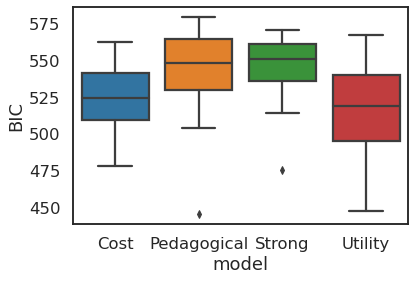

In [55]:
sns.boxplot(data=model_bic, x='model', y='BIC')

In [69]:
idx = model_bic.groupby(['subject'])['BIC'].transform(min) == model_bic['BIC']
best_model = model_bic[idx]
best_model.groupby(['model'])['subject'].agg('count')

model
Cost           14
Pedagogical     1
Utility        13
Name: subject, dtype: int64

In [56]:
model_bic.groupby(['subject'])

,model,subject,weight,temp,loglik,example,free_params,BIC
0,Cost,sub-01,0.000000,2.400000,-248.914475,108,1,502.511082
1,Pedagogical,sub-01,1.000000,0.100000,-256.915760,108,1,518.513650
2,Strong,sub-01,0.000000,0.000000,-257.201687,108,0,514.403374
3,Utility,sub-01,0.047737,2.587826,-248.111242,108,2,505.586746
4,Cost,sub-02,0.000000,2.800000,-260.084130,114,1,524.904458
...,...,...,...,...,...,...,...,...
107,Utility,sub-29,0.408144,4.144844,-255.352144,116,2,520.211468
108,Cost,sub-30,0.000000,4.100000,-261.615539,120,1,528.018570
109,Pedagogical,sub-30,1.000000,2.800000,-264.066052,120,1,532.919595
110,Strong,sub-30,0.000000,0.000000,-285.619164,120,0,571.238329


TypeError: boxplot() got an unexpected keyword argument 'fill'

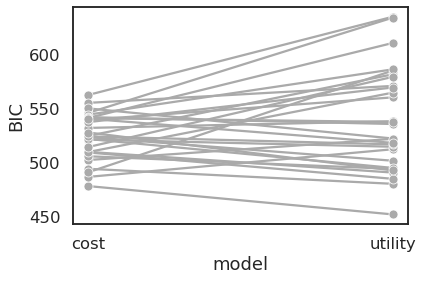

In [90]:
fig,ax=plt.subplots()
for sub,group in model_bic.groupby('subject'):
    sns.lineplot(data=group, x='model', y='BIC', marker='o', color='#aaa', ax=ax)
sns.boxplot(data=model_bic,x='model',y='BIC', fill=None)


In [89]:
?sns.boxplot

Signature:
sns.boxplot(
    *,
    x=None,
    y=None,
    hue=None,
    data=None,
    order=None,
    hue_order=None,
    orient=None,
    color=None,
    palette=None,
    saturation=0.75,
    width=0.8,
    dodge=True,
    fliersize=5,
    linewidth=None,
    whis=1.5,
    ax=None,
    **kwargs,
)
Docstring:
Draw a box plot to show distributions with respect to categories.

A box plot (or box-and-whisker plot) shows the distribution of quantitative
data in a way that facilitates comparisons between variables or across
levels of a categorical variable. The box shows the quartiles of the
dataset while the whiskers extend to show the rest of the distribution,
except for points that are determined to be "outliers" using a method
that is a function of the inter-quartile range.


Input data can be passed in a variety of formats, including:

- Vectors of data represented as lists, numpy arrays, or pandas Series
  objects passed directly to the ``x``, ``y``, and/or ``hue`` parameters.
- A 

## Plot predicted examples

Helper function: Convert sampling distribution into a heatmap

In [26]:
def sampling_matrix(row):    
    # matrix of full coordinates
    all_coords = pd.DataFrame([(i,j) for i in range(6) for j in range(6)],
                             columns=['row', 'col'])

    # get full sampling distribution
    pD = pd.DataFrame(row['pD'], columns=['idx', 'pD'])
    pD['coords'] = pD.idx.apply(lambda i: np.unravel_index(i, (6,6)))

    # "unravel" flat indices into 2d coordinates?
    coords_2d = pD.coords.apply(pd.Series)
    coords_2d.columns = ['row', 'col']

    # put it together
    pD = pd.concat([pD, coords_2d], axis=1)
    pD = pD.drop(columns=['idx', 'coords'])
    pD = all_coords.merge(pD,how='left')

    # convert df of coordinates into 2d matrix
    pD = pD.pivot('row', 'col', 'pD').values
    pD = np.nan_to_num(pD)
    
    return pD

Helper function: Plot model predictions for a given subject & problem

In [27]:
def plot_problem(subject, sub_data):

    # read problem
    prob_idx = sub_data.problem.values[0]
    prob = problems[prob_idx]
    true_h = np.array(prob['A'])
    h_mask = true_h == 0

    # make blank figure
    n_models = sub_data.model.nunique()
    n_trials = sub_data.ex_idx.nunique()
    fig,axes=plt.subplots(n_models, n_trials, figsize=(4*n_trials, 4*n_models))

    # fill in w/ data from each trial + model
    all_models = sub_data.model_label.unique()
    n_models = sub_data.model_label.nunique()

    for m in range(n_models):

        model = all_models[m]
        sub_model = sub_data[sub_data.model_label == model]

        for t in range(n_trials):
            row = sub_model.iloc[t]
            if n_trials > 1:   
                ax = axes[m][t]
            else:
                ax = axes[m]

            # draw sampling distribution
            sns.heatmap(sampling_matrix(row), mask=h_mask, square=True, cmap='viridis', cbar=False, ax=ax)
            ax.set_facecolor('#aaa')
            ax.set(title='t=%i' % t, xticklabels=[], yticklabels=[])

            if t == 0:
                ax.set(ylabel=model)

            # mark cursor start
            coords = eval_tuple(row.cursor_coords)
            ax.add_patch(Rectangle(coords[::-1], 1, 1, edgecolor='red', fill=False, lw=3))

            # mark cursor end
            ax.add_patch(Rectangle(row.example_coords[::-1], 1, 1, edgecolor='#00A2FF', fill=False, lw=3))        

    fig.suptitle('sub-%02d\nProblem %i' % (subject, prob_idx))

Let's test it out!

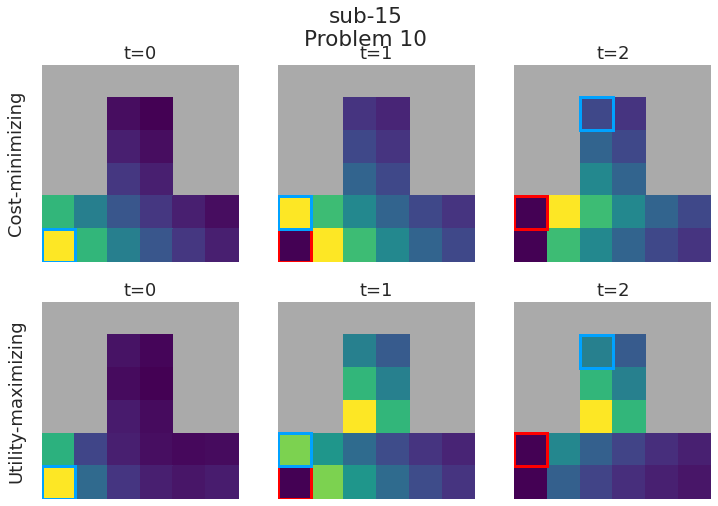

In [28]:
plot_problem(15, model_df[(model_df.subject == 15) & (model_df.problem == 10)] )

In [14]:
for (sub, sub_data) in model_df.groupby('subject'):
    out_file = 'plots/all_model_predictions/sub-%02d.pdf' % sub
    pdf = backend_pdf.PdfPages(out_file)

    for prob,prob_data in sub_data.groupby('problem'):
        fig = plot_problem(sub, prob_data)
        pdf.savefig(fig)
        plt.close(fig)
    
    pdf.close()

Plot best-fitting parameter values

In [29]:
cost_model.

[{'subject': 1,
  'run': 1,
  'block_idx': 0,
  'ex_idx': 0,
  'first_movement': '[0, 1]',
  'start': '[0, 0]',
  'problem': 22,
  'example': 8,
  'cursor_coords': '[0, 0]',
  'example_coords': [1, 2],
  'cursor': 0,
  'model': 'cost',
  'lik': 0.07311621911069176,
  'pD': [[1, 0.5402598447506067],
   [2, 0.0],
   [3, 0.0],
   [4, 0.026897953827010015],
   [7, 0.19875048977422338],
   [8, 0.07311621911069176],
   [9, 0.026897953827010015],
   [10, 0.009895204222535703],
   [13, 0.07311621911069176],
   [16, 0.003640242199663731],
   [19, 0.026897953827010015],
   [22, 0.0013391702661409953],
   [25, 0.009895204222535703],
   [26, 0.003640242199663731],
   [27, 0.0013391702661409953],
   [28, 0.000492653209141361],
   [31, 0.003640242199663731],
   [32, 0.0],
   [33, 0.0],
   [34, 0.00018123698727024175]],
  'pTrue': 0.3333333333333333,
  'pH': [['A', 0.3333333333333333],
   ['B', 0.3333333333333333],
   ['C', 0.0],
   ['D', 0.3333333333333333]],
  'entropy': 1.0986122886681096,
  'delt

In [ ]:
#     ### PLOT PREDICTIONS ### 
#     fig,ax=plt.subplots()
#     sns.lineplot(data = agg_predictions, x = 'tau', y = 'loglik', ax=ax)
#     ax.set(xlabel='Laziness (tau)', ylabel='Log likelihood', title='sub-%02d' % sub)

#     # label best parameter value
#     accent_col = '#fc8403'
#     mid_y = np.mean(ax.get_ylim())
#     ax.axvline(x=best_tau, linestyle='--', color=accent_col)
#     plt.text(best_tau+0.25, mid_y, 'tau = %0.2f' % best_tau, rotation=90, va='center', color=accent_col, weight='semibold')
    
#     # save subject search as a plot
#     plt.savefig(plot_dir + 'sub-%02d_model-pedagogical_desc-params.png' % sub)
#     plt.close()